<a href="https://colab.research.google.com/github/sbbwoy/ESAA/blob/main/%EB%B6%84%EB%A5%982_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**스태킹 앙상블**

개별 알고리즘을 결합해 예측 결과 도출 (bagging과 boosting 공통)

차이점? 예측 데이터를 기반으로 다시 예측 수행 --> 메타 모델

스태킹 모델
1. 개별적 기반 모델
2. 최종 메타 모델

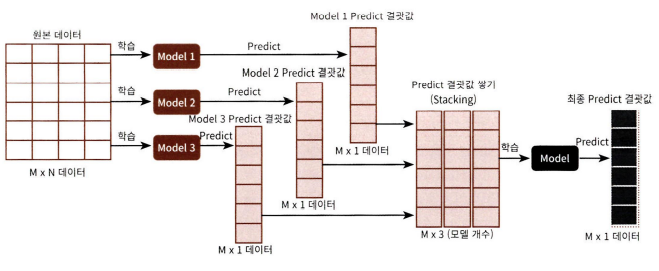

In [3]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [5]:
#개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

In [6]:
#개별 모델 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [10]:
#학습된 개별 모델들이 각자 반환하는 예측 데이터 세트 생성 후 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [12]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [13]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도 : 0.9649


스태킹 기법으로 예측한다고 무조건 개별 모델보다 좋아진다는 보장은 없음

**CV 세트 기반의 스태킹**

step 1. 각 모델별 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터 생성

step 2. step1에서 개별 모델들이 생성한 학습용데이터를 모두 스태킹 형태로 합쳐 메타 모델이 학습할 최종 학습용 데이터 세트 생성. 각 모델들이 생성한 테스트용 데이터도 스태킹 형태로 합쳐 메타 모델이 예측할 최종 테스트 데이터 세트 생성.

메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레이블 데이터를 기반으로 평가

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터 생성 함수
def get_stacking_base_datsets(model, X_train_n, y_train_n, X_test_n, n_folds):
    #지정된 n_forlds값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False) #shuffle=False라 random_state를 사용할 수 없는듯??
    #추후 메타 모델이 사용할 학습 데이터 반환을 위한 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, ' model 시작 ')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, ' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, trest_pred_mean은 테스트 데이터
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean
    

In [23]:
knn_train, knn_test = get_stacking_base_datsets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datsets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datsets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datsets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
	 폴드 세트:  5  시작
	 폴드 세트:  6  시작


In [24]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape, 
      '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [26]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


## 11 정리

* 결정 트리 알고리즘: 정보의 균일도에 기반한 규칙 트리로 예측 수행. 다른 알고리즘에 비해 비교적 직관적이지만 과적합 발생 가능성 높음

* 앙상블 기법: 배깅 & 부스팅

- 배깅: 학습 데이터를 중복을 허용하면서 다수의 세트로 샘플링 --> 다수의 하위 학습기가 학습한 뒤 최종 결과 결합 후 예측 ex. 랜덤 포레스트. 수행시간이 빠르고 안정적인 예측

- 부스팅: 순차적 학습으로 예측이 틀린 데이터에 대해 가중치 부여로 다음 학습기에서 보다 높은 정확도를 보임. GBM은 뛰어난 예측 성능을 가지나 수행 시간이 오래 걸린다는 단점.
XGBoost와 LightGBM은 현재 가장 주목 받는 부스팅 기반 머신러닝 패키지. 빠르고 예측 성능 높음.

* 스태킹 모델: 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모데링 학습할 별도의 학습 데이터 세트와 예측할 테스트 데이터 세트를 재생성하는 기법. 스태킹 모델의 핵심은 바로 메타 모델이 사용할 학습 데이터 세트와 예측 데이터 세트를 개별 모델의 예측 값들을 스태킹 형태로 결합 후 생성하는 데 있음.